# **University Class Project: Leveraging Machine Learning for Revenue Optimization via Strategic Couponing**

#**Instructions**

Many customers order only once in an online store. There are several reasons why they don’t place another order. To counteract this, online retailers use various customer loyalty measures. One measure, for example, is to send coupons sometime after an initial order has been placed. The intention is to encourage the customer to make a follow-up purchase. Even though the vouchers don’t cost the online retailer anything directly, it is not a good solution to send all customers a discount voucher: Some customers would make a follow-up purchase even without a voucher. In this case, a redeemed discount means less revenue for the online retailer. Therefore, it is crucial to devise a more targeted approach for distributing these vouchers.

# **Task**

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a
specific customer. The model should be designed to predict if a customer will place a follow-up purchase within 90 days following their initial purchase. This information is represented by the target90 variable in the dataset. Each customer who is predicted to not place a subsequent order will be sent a voucher.

Empirical analyses by the media retailer have shown that for 25% of the churning customers, the voucher triggers a purchase with an average order value of €10. So if a voucher is sent to a customer who would not have bought again, revenue increases by an average of €1.25. Conversely, sending a voucher to a customer who would have placed an order anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues.

The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.

## **1. Import Packages**

In [ ]:
pip install great_tables -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.2/607.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
pip install dtreeviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip uninstall scikit-learn -y -q

In [ ]:
pip install scikit-learn==1.3.2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.2 MB/s eta 0:00:00


In [ ]:
pip install lime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# General Packages
import pandas as pd
import numpy as np
import math
import re
import os

#Import Data from Google Drive
from google.colab import drive # Used to access Google Drive to import data
import shutil # Used to copy data from Google Drive

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from great_tables import GT, md, style, loc

#Working with Data
from sklearn.impute import SimpleImputer #Replaces missing values with the median of the column
from sklearn.model_selection import train_test_split #Splits data into test and training data

#Model Training
from sklearn import tree
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier #Decision Tree Model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier #Esemble Models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Randomized Search
from sklearn.metrics import make_scorer #Create custom scorer for hyper-parameter tuning to maximize expected revenue
import joblib #Save to Google Drive
import pickle #Save to Google Drive


from xgboost import XGBClassifier

#Performance Evaluation & Model Interpretation
from sklearn.metrics import confusion_matrix #Creates a confusion matrix
from sklearn.metrics import accuracy_score #Calculates the accuracy score of two columns

from sklearn.inspection import PartialDependenceDisplay as pdp #PDP
from sklearn.inspection import permutation_importance

from lime import lime_tabular #LIME
import shap #SHAP

## **2. Import Data**

In [ ]:
#Mount to Google Drive to be able to access data
drive.mount('/content/drive')

#Define general path
path_dir = "/content/drive/My Drive/2) College & Other Education/1) College/1) Master of Science Data Science in Business & Economics/3. Semester/DS405_Machine_Learning_Applications_in_Business_and_Economics/Mini_Project/"

Mounted at /content/drive


In [ ]:
#Copies data to Google Colab
shutil.copy(f"{path_dir}/Input_Data/test.csv", "test.csv")
shutil.copy(f"{path_dir}/Input_Data/train.csv", "train.csv")

'train.csv'

In [ ]:
#Creates dataframes from csv files
train_val_data_original = pd.read_csv("train.csv", delimiter = ";")
test_data_original = pd.read_csv("test.csv", delimiter = ";")

<ipython-input-9-8c567283ab06>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
<ipython-input-9-8c567283ab06>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


## **3. Explorative Data Analysis & Train, Validation, Test Split**

### **3.1 Explorative Data Analysis (Pre Data Processing)**

#### **3.1.1 Functions**

In [ ]:
#For nice plotting of tables
def getNiceTable(data, title, subtitle):
  nice_table = (
    GT(data)

    .tab_header(
        title = title,
        subtitle = subtitle,
    )
  )

  return nice_table

In [ ]:
def getVariableDistributionsTable(data, variables, labels):

  #Adds first two columns
  columns = ["", "Variable = 0", "Variable = 1", "Variable Explanation"]

  #Creates new table
  result_table = pd.DataFrame(columns=columns)

  #Count Variable for labels
  i = 0

  for variable in variables:

    #Gets percentages
    value_counts = data.groupby(variable)["target90"].value_counts().unstack(fill_value = 0)

    #Calculates total value counts
    total_variable_0 = value_counts.iloc[0, 0] + value_counts.iloc[0, 1]
    total_variable_1 = value_counts.iloc[1, 0] + value_counts.iloc[1, 1]

    #Calculates percentages
    percent_target90_1_variable_0 = round(value_counts.iloc[0, 1] / total_variable_0 * 100, 2)
    percent_target90_1_variable_1 = round(value_counts.iloc[1, 1] / total_variable_1 * 100, 2)

    #Creates values for new row
    new_table_values = [variable, percent_target90_1_variable_0, percent_target90_1_variable_1, dummy_variables_labels[i]]

    #Increase Count Variable by 1
    i = i + 1

    #Adds new row to table
    result_table.loc[len(result_table)] = new_table_values

  return result_table

In [ ]:
#Helper function to get non matching values
def getNonMatchingValues(dataset1, dataset2, column):

  delta_1 = set(dataset1[column]) - set(dataset2[column].unique())
  delta_2 = set(dataset2[column]) - set(dataset1[column].unique())

  result = list(delta_1) + list(delta_2)

  return result

In [ ]:
def plotHistogramWithTarget(dataset, column, bins, title, x_label, y_label, upper_limit = None, above_zero = False):

    #If wanted, subset dataset to only include values above 0
    if above_zero:
      dataset = dataset[dataset[column] > 0].reset_index(drop = True)

    #Take only wanted column
    process_column = dataset[column]

    #Creates histogram. Source: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
    if upper_limit != None:
      #Cap creating new bins above a given limit
      capped_column = np.minimum(process_column, upper_limit) #Sets value to upper limit if reached (The bin on the right will be bigger)

      frequencies, bin_edges = np.histogram(capped_column, bins = bins, range = (capped_column.min(), upper_limit))
    else:
      capped_column = process_column

      frequencies, bin_edges = np.histogram(capped_column, bins = bins)

    #Source: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html
    bin_indices = np.digitize(capped_column, bin_edges, right = True)

    # Calculate average repurchase for each bin
    target_means = []

    #Loop over all bins
    for i in range(1, len(bin_edges)):

        #Source: https://hackernoon.com/probabilistic-predictions-in-classification-evaluating-quality
        current_bin_structure = bin_indices == i

        #Gets mean for curent bin
        bin_mean = dataset.loc[current_bin_structure, "target90"].mean()

        #Appends values
        target_means.append(bin_mean)

    #Create graph
    plt.figure(figsize=(12, 6))

    bar_positions = (bin_edges[:-1] + bin_edges[1:]) / 2
    bar_width = np.diff(bin_edges)

    #Creates histogram
    plt.bar(bar_positions, frequencies, width = bar_width, color = "skyblue", edgecolor = "black", align = "center", alpha = 0.7)

    #Adds mean as text above each bar
    for i in range(len(bar_positions)):

      position = bar_positions[i]
      frequency = frequencies[i]
      target_mean = target_means[i]

      if frequency > 0:
        mean = round(target_mean, 2)
        plt.text(position, frequency + 1, f"{mean}", ha = "center", va = "bottom")

    #Adds title & labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    #Shows plot
    plt.show()

In [ ]:
def plotBarDistOfVariable(dataset, column, title, x_label, y_label, plot_width = 20, plot_height = 6):

  #Calculates the percentage. -> How many of each value of column purchased again?
  percentage = dataset.groupby(column)["target90"].mean() * 100

  #Calculate average repurchase
  average_repurchase = dataset["target90"].mean() * 100

  #Calculate difference to see which group over/underperforms the average
  percentage = percentage - average_repurchase

  #Calculates the weights of each value in the column
  counts = dataset.groupby(column)["target90"].count()
  total_count = dataset[column].count()
  weights = counts / total_count

  #Sort the data
  combined = pd.DataFrame({"weights": weights, "percentage": percentage})
  combined = combined.sort_values(by = "weights", ascending = False)

  #Gets the weights and sorted percentage out/underperformance values
  weights_sorted = combined["weights"].values
  percentage_sorted = combined["percentage"].values

  #Adds to the x-labels

  x_tick_labels = []

  i = 0
  #Loop over all advertising codes
  for value_comb in combined.index:

    #Gets weight of current adv code
    weight = round(weights_sorted[i] * 100, 2)

    #Creates new x tick label
    x_tick_label = f"{value_comb} ({weight}%)"
    x_tick_labels.append(x_tick_label)

    #Increases i by 1
    i = i +1

  #Creates plot
  plt.figure(figsize = (plot_width, plot_height))

  #Bars
  bars = plt.bar(combined.index, percentage_sorted, color = "skyblue")

  #Adds the percentages on top of each bar
  for bar in bars:
      bar_percentage = round(bar.get_height(), 2)
      plt.text(bar.get_x() + bar.get_width() / 2, bar_percentage + 1, f"{bar_percentage}%", ha = "center", va = "bottom")

  #Adds limits for better visualization
  max_value = max(percentage_sorted)
  min_value = min(percentage_sorted)

  #Adds puffer on top and below
  plt.ylim(min_value - 5, max_value + 5)

  #Sets title & labels
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  #Adds labels to x-ticks and rotates them
  plt.xticks(combined.index, x_tick_labels, rotation = 45)

  #Shows plot
  plt.show()

#### **3.1.1 Explorative Data Analysis  (Pre Data Processing)**

##### **3.1.1.1 Data Distribution**

###### **Ordinal & Nominal Variables**

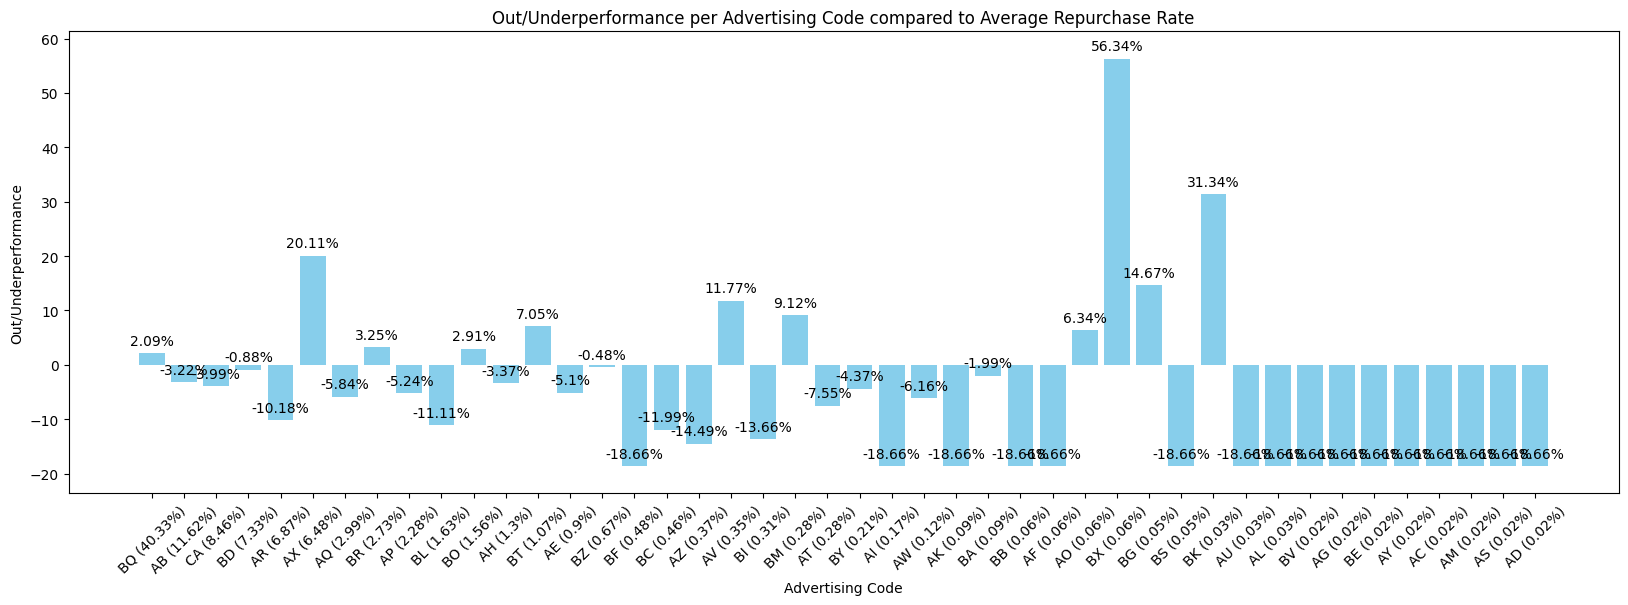

In [ ]:
plotBarDistOfVariable(train_val_data_original, "advertisingdatacode", "Out/Underperformance per Advertising Code compared to Average Repurchase Rate", "Advertising Code", "Out/Underperformance")

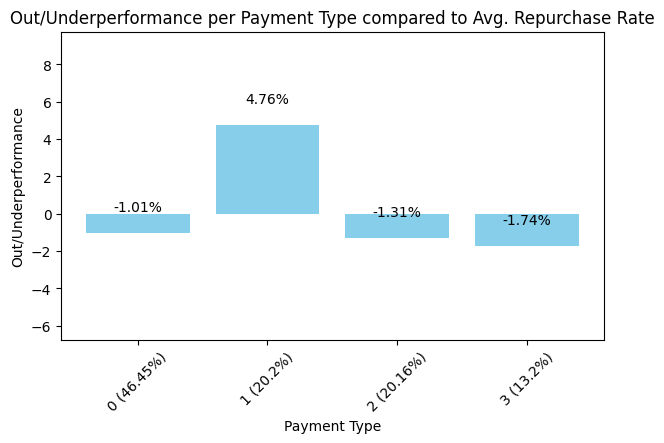

In [ ]:
plotBarDistOfVariable(train_val_data_original, "paymenttype", "Out/Underperformance per Payment Type compared to Avg. Repurchase Rate", "Payment Type", "Out/Underperformance", plot_width = 7, plot_height = 4)

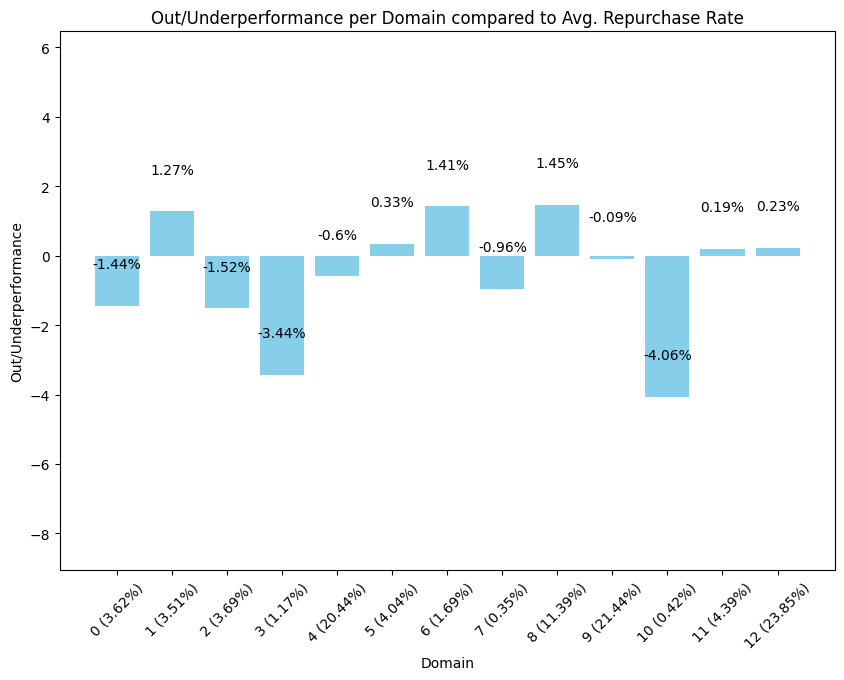

In [ ]:
plotBarDistOfVariable(train_val_data_original, "domain", "Out/Underperformance per Domain compared to Avg. Repurchase Rate", "Domain", "Out/Underperformance", plot_width = 10, plot_height = 7)

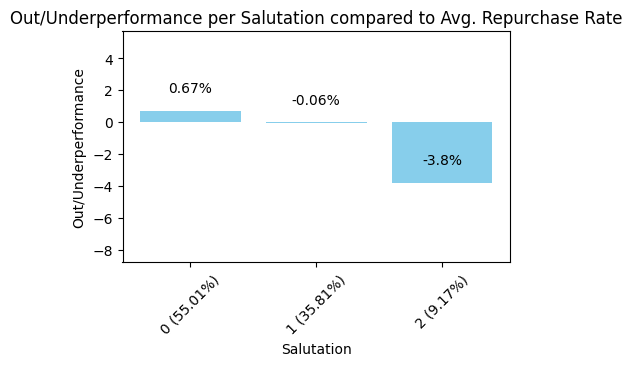

In [ ]:
plotBarDistOfVariable(train_val_data_original, "salutation", "Out/Underperformance per Salutation compared to Avg. Repurchase Rate", "Salutation", "Out/Underperformance", plot_width = 5, plot_height = 3)

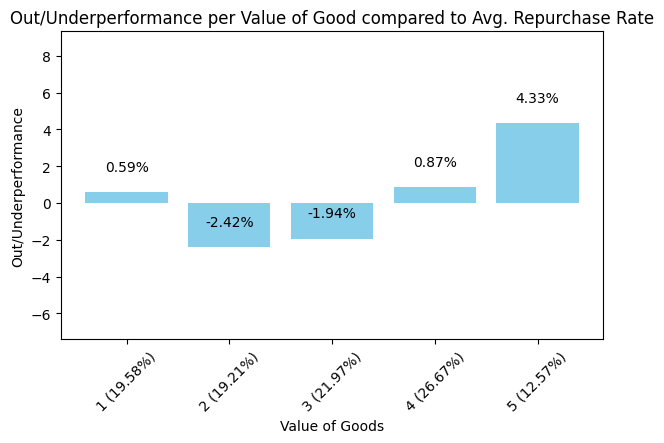

In [ ]:
plotBarDistOfVariable(train_val_data_original, "case", "Out/Underperformance per Value of Good compared to Avg. Repurchase Rate", "Value of Goods", "Out/Underperformance", plot_width = 7, plot_height = 4)

In [ ]:
dummy_variables = ["title", "newsletter", "deliverytype", "voucher", "gift", "entry", "shippingcosts"]
dummy_variables_labels = ["Had Title",
                          "Subscribed to Newsletter",
                          "Dispatch (0) vs. Collection (1)",
                          "Voucher Redeemed",
                          "Gift Option",
                          "Entry via Shop (0) vs. Partner (1)",
                          "Shipping Costs Incurred"]

dummy_variables_dist = getVariableDistributionsTable(train_val_data_original, dummy_variables, dummy_variables_labels)

dummy_variables_dist_table = getNiceTable(dummy_variables_dist, "Repurchase Distribution of Dummy Variables", "Shows how many percent of people purchased again within 90 days within the variable group")
dummy_variables_dist_table

GT(_tbl_data=                  Variable = 0  Variable = 1  \
0          title         18.66         18.14   
1     newsletter         17.20         25.82   
2   deliverytype         17.45         23.42   
3        voucher         19.16         16.06   
4           gift         18.67         16.22   
5          entry         17.31         20.57   
6  shippingcosts         19.82         12.10   

                 Variable Explanation  
0                           Had Title  
1            Subscribed to Newsletter  
2     Dispatch (0) vs. Collection (1)  
3                    Voucher Redeemed  
4                         Gift Option  
5  Entry via Shop (0) vs. Partner (1)  
6             Shipping Costs Incurred  , _body=<great_tables._gt_data.Body object at 0x7c9d2460c410>, _boxhead=Boxhead([ColInfo(var='', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='Variable = 0', type=<ColInfoTypeEnum.default: 1>, column_label='Variable = 0', column_align='right', column_width=None), ColInfo(var='Variable = 1', type=<ColInfoTypeEnum.default: 1>, column_label='Variable = 1', column_align='right', column_width=None), ColInfo(var='Variable Explanation', type=<ColInfoTypeEnum.default: 1>, column_label='Variable Explanation', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7c9d1e5554d0>, _spanners=Spanners([]), _heading=Heading(title='Repurchase Distribution of Dummy Variables', subtitle='Shows how many percent of people purchased again within 90 days within the variable group', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7c9d24b23590>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid')

As can be seen in the data:


- Many advertising codes over and underperform the average repurchase rate. For example, the advertising code AO has 56.34% more observations that purchase again within 90 days compared to the overall average of all observations. However, this specific group of observations makes up around 0.06% of the training data. Similarly many other advertising codes seem like they provide a better indication of future purchasing behavior. However, this cannot be used very well for generalizations as very few observations actually have these advertising codes. Rather promising seems the advertising code AX which makes up 6.48% of the data and outperforms the average by 20.11%. Being in this advertising group therefore seems to lead to a higher chance of a repurchase within 90 days.

- There are only slight out/underperformances for the variables paymenttype (Cash, Card, etc.), domain (Type of E-Mail Address), salutation (Female, Male or a Company) and case (Value of Goods). None of them seem to provide any meaningful information on their own.

- According to the table above, having subscribed to a newsletter, having used the delivertype Collection, having entered the shop via a partner, not having paid shipping cost and not having redeemed a voucher seems to make you more likely to purchase again within 90 days. However, having a title or not makes no difference.

###### **Cardinal Variables**

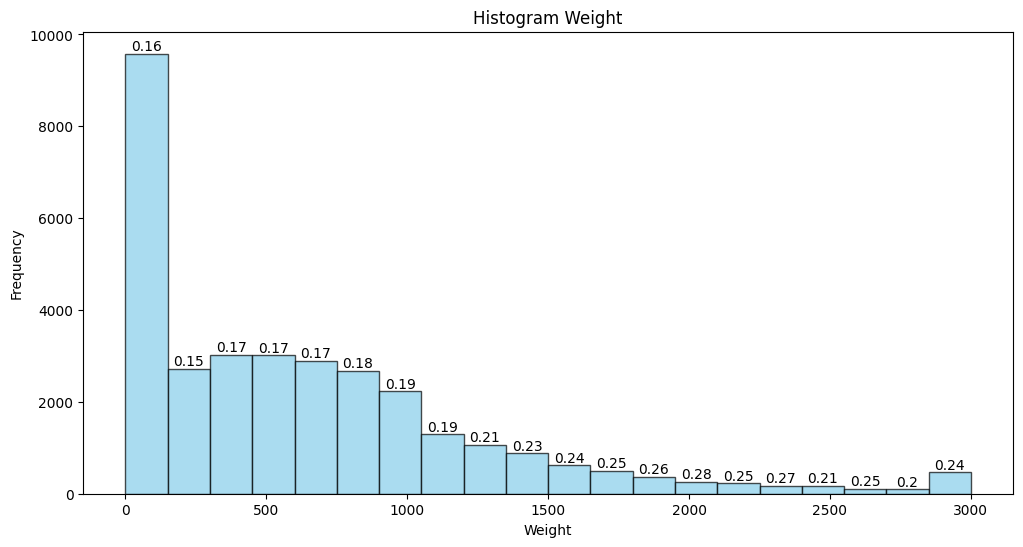

In [ ]:
plotHistogramWithTarget(
    dataset = train_val_data_original,
    column = "weight",
    bins = 20,
    title = "Histogram Weight",
    x_label = "Weight",
    y_label = "Frequency",
    upper_limit = 3000,
    above_zero = False
)

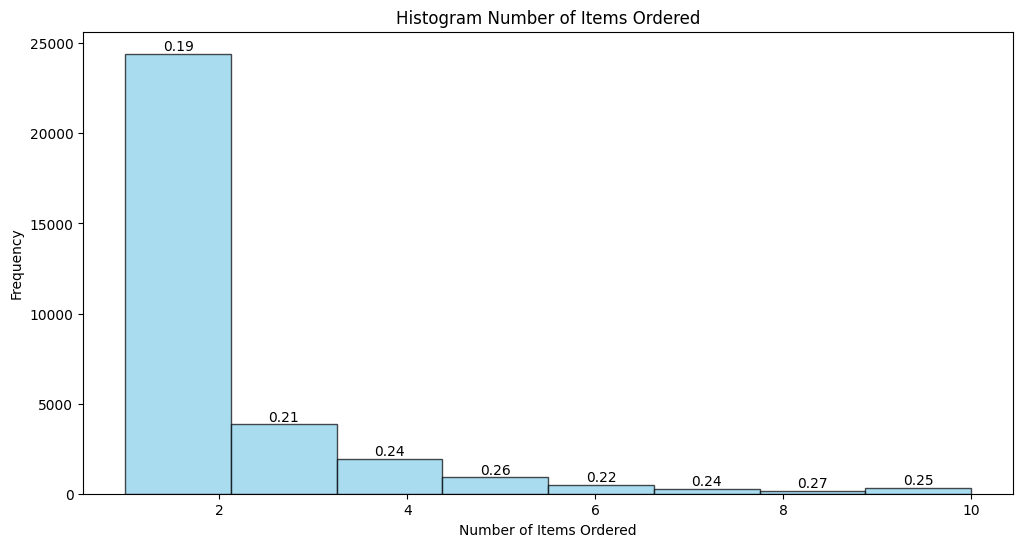

In [ ]:
plotHistogramWithTarget(
    dataset = train_val_data_original,
    column = "numberitems",
    bins = 8,
    title = "Histogram Number of Items Ordered",
    x_label = "Number of Items Ordered",
    y_label = "Frequency",
    upper_limit = 10,
    above_zero = False
)

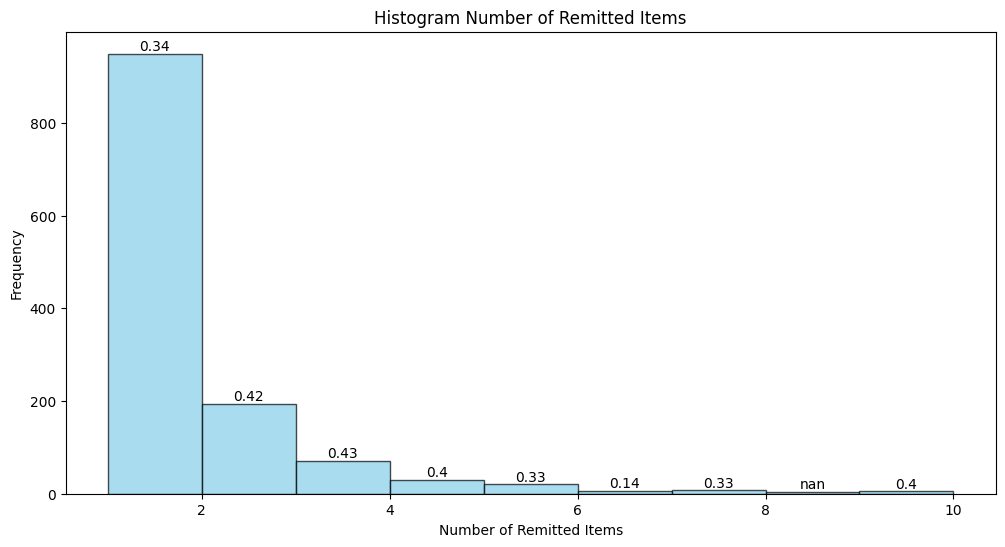

In [ ]:
plotHistogramWithTarget(
    dataset = train_val_data_original,
    column = "remi",
    bins = 9,
    title = "Histogram Number of Remitted Items",
    x_label = "Number of Remitted Items",
    y_label = "Frequency",
    upper_limit = 10,
    above_zero = True
)

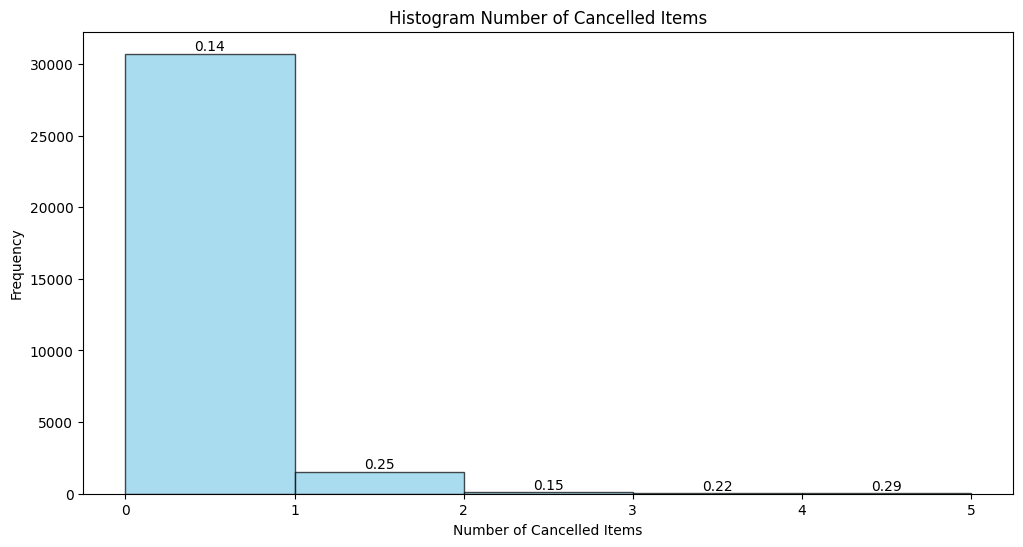

In [ ]:
plotHistogramWithTarget(
    dataset = train_val_data_original,
    column = "cancel",
    bins = 5,
    title = "Histogram Number of Cancelled Items",
    x_label = "Number of Cancelled Items",
    y_label = "Frequency",
    upper_limit = 5,
    above_zero = False
)

As can be seen in the data:


- Having previously been shipped a package with higher weight & more items (obviously the two are correlated) leads to a higher possibility of retention.
- A slight increase in the number of remitted items over zero seems to indicate a higher retention rate as well. This is likely due to people returning items and making another purchase right after to get a different item that better fits their needs as the returned item didn't fit them.
- The number of cancelled items also has a positive correlation with retention (Although most observations are between 0 and 1). This feature likely won't provide much meaningful information.

##### **3.1.1.2 Variation of Data**

In [ ]:
#This prints the columns that only have 1 unique value. Those columns can be dropped as they don't provide any information.
no_variation_columns = [column for column in train_val_data_original.columns if train_val_data_original[column].nunique() == 1]
print("Variables with no Variation (i.e. there is only one unique value):", no_variation_columns)

Variables with no Variation (i.e. there is only one unique value): ['points']


The column points has only one value and no variation. Therefore, it will be dropped later

##### **3.1.1.3 Mixed Data Types**

During importing, the script already told me that the columns invoicepostcode and delivpostcode of the train and test dataset contain mixed types, meaning that there are columns that have numbers and strings in it. I will therefore later convert all of the values back to numbers and replace the strings like NW and OX, etc. with replacement values of -2, -3 and so on. This will insure that I won't add numbers to the dataset that are already included and that I also have only numbers in the dataset.



In [ ]:
print(train_val_data_original["invoicepostcode"].unique())
print(train_val_data_original["delivpostcode"].unique())

print(test_data_original["invoicepostcode"].unique())
print(test_data_original["delivpostcode"].unique())

[58 34 51 25 41 95 78 77 86 97 50 40 99 85 88 17 70 30 68 15 12 63 18 89
 49 20 42 21 73 22 55 23  7 65 79 57 46 27 10 52 66 91 24 74 61 56 76 38
 26 32 39 84 29 33  1 16 13 80  2 14 45 81 53 90 60  3 64 54 71 28 36 67
 44 31 47 35  9  4 69 59 92 93 37 48 94 96 72 83 75  8 82  6 87 19 98 11
  0]
[nan 99.0 97.0 15.0 70.0 50.0 14.0 53.0 35.0 24.0 44.0 22.0 41.0 45.0 88.0
 58.0 64.0 91.0 81.0 42.0 46.0 27.0 4.0 52.0 72.0 17.0 23.0 21.0 60.0 55.0
 82.0 28.0 30.0 10.0 90.0 67.0 86.0 40.0 51.0 59.0 65.0 57.0 94.0 63.0
 49.0 7.0 92.0 85.0 71.0 47.0 96.0 80.0 73.0 34.0 37.0 76.0 13.0 48.0 16.0
 6.0 25.0 12.0 89.0 66.0 69.0 8.0 20.0 1.0 79.0 0.0 33.0 32.0 98.0 83.0
 95.0 93.0 78.0 31.0 61.0 38.0 36.0 74.0 54.0 2.0 19.0 56.0 18.0 68.0 75.0
 3.0 29.0 87.0 9.0 11.0 39.0 26.0 77.0 84.0 '61' '53' '23' '52' '81' '25'
 '44' '13' '33' '50' '99' '65' '56' '14' '68' '72' '49' '46' '22' '76'
 '04' '86' '41' '57' '45' '38' '55' '66' '37' '71' '21' '89' '47' '20'
 '40' '58' '97' '64' '88' '48' '31' '69' '36

##### **3.1.1.4 Nominal Values contained in Train but not in Test & Vice Versa**

In [ ]:
getNonMatchingValues(test_data_original, train_val_data_original, "advertisingdatacode")

['BW', 'AJ', 'BH', 'BU', 'AA', 'BN', 'AC', 'AU', 'AS', 'BG']

The column "advertisingdatacode" has values that are contained in train but not in test and vice versa. I will encode this variable so this will be a problem for training if there will be variables used that are not available during test and the other way around. Therefore, I will create new columns later that will contain all 0 for the variables that are missing.

### **3.2 Creating New Features, Dealing with Missing Values, Feature Selection & Feature Encoding**

#### **3.3.1 Functions**

In [ ]:
#Helper Function that checks if a value is a string or not.
#Using the float function as some values are actually numerical but saved as string
def isString(value):
  try:
    float(value)
    return False
  except (ValueError, TypeError):
    return True

In [ ]:
#Helper Function to get the unique string values (used for columns invoicepostcode and delivpostcode)
def getUniqueStringAndReplacementNumberOfColumn(datasets, column):

  #Unique Values for each column that I have in the list
  unique_values = set()

  #Loop over all datasets to get these unique values for the current column
  for dataset in datasets:

    #Get all values of the current column
    data = dataset[column]

    #Get the unique string values of the current column
    string_values = data[data.apply(isString)].dropna().unique()

    #To make sure I don't add a list to a list but the raw values, I loop over each value in the list
    unique_values.update(string_values)

  #I then sort the values in ascending order
  sorted_values = sorted(unique_values)

  #I then assign to each string a new number. This number will be added to the original column to make the entire column numerical.
  value_to_number = {value: -2 - i for i, value in enumerate(sorted_values)}

  #Return dictionary
  return value_to_number

In [ ]:
def addDateInformation(dataset, field_name, prefix, drop = True):

  #Get Date column
  field = dataset[field_name]

  #List with all types of dates I want to create
  date_types = ["Year", "Month", "Week", "Day", "Dayofweek", "Dayofyear", "Is_month_end", "Is_month_start",
            "Is_quarter_end", "Is_quarter_start", "Is_year_end", "Is_year_start"]

  #Specific solution for week
  week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, "isocalendar") else field.dt.week

  #Loops over all date types in list and calculates them accordingly (except for week)
  for date_type in date_types:
    dataset[prefix + date_type] = getattr(field.dt, date_type.lower()) if date_type != "Week" else week

  #Drops original column if requested
  if drop:
    dataset.drop(field_name, axis = 1, inplace = True)

  #Returns dataset
  return dataset

In [ ]:
#This function adds missing columns to the dataset.
#This is specifically meant for the column "advertisingdatacode" as there is a mismatch between train and test dataset
def addMissingColumns(dataset, column_to_check):

  non_matching_values = getNonMatchingValues(test_data_original, train_val_data_original, column_to_check)

  #Checks if column is contained in dataset
  for non_matching_value in non_matching_values:

    column_name = f"advertisingdatacode_{non_matching_value}"

    #If not in dataset, create column with 0 values
    if column_name not in dataset.columns:
      dataset[column_name] = 0

  return dataset

In [ ]:
def getOnlyIntegerValues(dataset, column):

  #Gets the unique list of strings for all datasets that we have and assigns new values to the strings
  unique_values = getUniqueStringAndReplacementNumberOfColumn([train_val_data_original, test_data_original], column)

  #Replaces values
  dataset[column] = dataset[column].replace(unique_values)

  #Replaces missing values with a -1
  dataset.fillna({column: -1}, inplace = True)

  #Converts string values to numeric values
  dataset[column] = pd.to_numeric(dataset[column]).astype(int)

  return dataset

In [ ]:
def prepareDataSet(dataset):

  ################### DATE Variables ###################

  #
  #   deliverydatepromised has Year 4746 assigned values (count = 9)
  #   deliverydatereal has 0000-00-00 total values (count = 5472)
  #   advertisingdatacode train data has different values than test data
  #   -> Find all types of both tables and add the missing values to both train and test and just set them 0.
  #

  #Converting all Date Columns to DateTime Format
  date_columns = ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]

  for col in date_columns:
      dataset[col] = pd.to_datetime(dataset[col], errors = "coerce")

      #Missing dates or if the year is larger than 2024 (i.e. 4746 for example = Bad data), I replace the data with the median values
      invalid_dates = dataset[col].isna() | (dataset[col].dt.year > 2024)

      median_date = dataset.loc[~invalid_dates, col].median()
      dataset.loc[invalid_dates, col] = median_date

  # I create new columns based on the date columns which convey potentially more useful information rather than the raw dates
  #
  # days_until_first_order = Equal to the number of days between the creation of the account and the first order being placed
  # delivery_delay_days = Equal to the number of days between the promised delivery date and the actual delivery date

  dataset["days_until_first_order"] = (dataset["date"] - dataset["datecreated"]).dt.days
  dataset["delivery_delay_days"] = (dataset["deliverydatereal"] - dataset["deliverydatepromised"]).dt.days

  dataset["delivery_delay"] = (dataset["delivery_delay_days"] > 0).astype(int) # = 1 if there were any delayed days
  dataset["significant_delivery_delay"] = (dataset["delivery_delay_days"] > 10).astype(int) # = 1 if there was a delay above 10 days

  dataset = addDateInformation(dataset, "date", "firstOrder")
  dataset = addDateInformation(dataset, "datecreated", "accountCreated")
  dataset = addDateInformation(dataset, "deliverydatepromised", "deliveryPromised")
  dataset = addDateInformation(dataset, "deliverydatereal", "deliveryReal")

  ################### Specific Columns: invoicepostcode & delivpostcode ###################

  #Replaces string values like "OX" or "NW" with numbers and then adjusts entire column to contain only numbers
  dataset = getOnlyIntegerValues(dataset, "delivpostcode")
  dataset = getOnlyIntegerValues(dataset, "invoicepostcode")

  ################### Nominal Variables ###################

  #Encode variables that are nominal
  variables_to_encode = ["salutation",
                         "model",
                         "paymenttype",
                         "delivpostcode",
                         "invoicepostcode",
                         "advertisingdatacode"
                         ]

  dataset = pd.get_dummies(dataset, columns = variables_to_encode, drop_first = True)
  dataset = dataset.replace({False: 0, True: 1})

  ################### Specific Columns: advertisingdatacode ###################

  #Add remaining values for column advertisingdatacode that are not contained in this dataset
  dataset = addMissingColumns(dataset, "advertisingdatacode")

  ################### Ordinal Variables ###################

  value_goods = "Low", "Low/Medium", "Medium", "Medium/Large", "Large"

  dataset["case"] = dataset["case"].astype('category')
  dataset["case"] = dataset["case"].cat.set_categories(value_goods, ordered = True)

  ################### Dropping not needed columns ###################

    #Dropping not needed columns (i.e. columns that likely won't explain anything)
  drop_columns = ["customernumber",
                  "title",
                  "domain",
                  "points" #Has only value of 0 -> Drop as no variation
                  ]

  dataset = dataset.drop(columns = drop_columns)

  ################### Other Conversion Stuff ###################

  cols_categorical = dataset.select_dtypes(exclude = np.number).columns.tolist()

  #Converts Categorical Columns to Numeric Categorical Columns
  dataset[cols_categorical] = dataset[cols_categorical].apply(lambda x:x.astype("category").cat.codes)

  ################### Handling Missing Data ###################

  #I fill missing values of the delivery delays with 0 assuming that they arrived on time.
  dataset.loc[:, "delivery_delay_days"] = dataset["delivery_delay_days"].fillna(0)

  #COLUMN SOLUTIONS NEEDED FOR:

  #
  # - invoicepostcode
  # - delivpostcode
  #

  #Calculates median of columns (Median reduces affect of outliers)
  imputed_median = SimpleImputer(missing_values = np.nan, strategy = "median")
  imputed_median.fit(dataset)

  #Replaces remaining dataset with median values for missing values
  dataset = pd.DataFrame(imputed_median.transform(dataset), columns = dataset.columns)

  return dataset

#### **3.3.2 Creating New Features, etc.**

Based on the explorative data analysis from above, I process the data in the following way:

- I create dummy variables for specific dates (i.e. Day of Week, Quarter Start/End, etc)
- I calculate time differences (i.e. how many days until delivery after order was placed, etc.)
- I create a dummy variable to indicate if there was a delivery delay
- I encode nominal variables via One-Hot-Encoding
- I process ordinal variables by reordering them
- I drop not needed columns. Those are columns that are likely not going to provide any meaningful information.
- I handle missing data depending on the type of column
- Preprocessed the columns advertisingdatacode, invoicepostcode and delivpostcode as described above

Specifics can be found in the comments of the code function above.

In [ ]:
train_val_data_original_copy = train_val_data_original.copy()
test_data_original_copy = test_data_original.copy()

train_val_data = prepareDataSet(train_val_data_original_copy)
test_data = prepareDataSet(test_data_original_copy)

<ipython-input-33-4dce76bdf1cf>:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<ipython-input-33-4dce76bdf1cf>:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [ ]:
test_data

,newsletter,deliverytype,voucher,case,numberitems,gift,entry,shippingcosts,weight,remi,...,advertisingdatacode_BW,advertisingdatacode_BX,advertisingdatacode_BY,advertisingdatacode_BZ,advertisingdatacode_CA,advertisingdatacode_AA,advertisingdatacode_AC,advertisingdatacode_AU,advertisingdatacode_AS,advertisingdatacode_BG
0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,0.0,260.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,719.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,636.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32422,0.0,0.0,0.0,-1.0,7.0,0.0,0.0,0.0,2406.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32423,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32424,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32425,0.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,1765.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **3.3 Train, Validation, Test Split**

In [ ]:
print("Target Variable Count:")
print(train_val_data["target90"].value_counts())

Target Variable Count:
target90
0.0    26377
1.0     6051
Name: count, dtype: int64


In [ ]:
#Set Sample Size for equal weighted training data
sample_size = 4500

#Get unique values for each label
train_data_target90_1 = train_val_data[train_val_data["target90"] == 1]
train_data_target90_0 = train_val_data[train_val_data["target90"] == 0]

#Get number of observations for each label
target90_1_size = len(train_data_target90_1)
target90_0_size = len(train_data_target90_0)

#Get sample size for each label
sample_size_1 = int(target90_1_size * 0.8)
sample_size_0 = int(target90_0_size * 0.8)

#Sample observations for each label
sample_train_data_target90_1 = train_data_target90_1.sample(n = sample_size_1, random_state = 603)
sample_train_data_target90_0 = train_data_target90_0.sample(n = sample_size_0, random_state = 603)

#Now I oversample the minority class to create an equally distributed dataset by duplicating minority class samples.
ratio = int(target90_0_size / target90_1_size) #This is how often the minority label will be duplicated

#This is the base for the loop
train_data = pd.concat([sample_train_data_target90_0, sample_train_data_target90_1])

#This is the validation set containing the remaining observations
validation_data = train_val_data.drop(train_data.index)

#Here i duplicate the minority class labels
for i in range(1, ratio):
  train_data = pd.concat([train_data, sample_train_data_target90_1])

#Reset Indices
train_data = train_data.reset_index(drop = True)
validation_data = validation_data.reset_index(drop = True)

In [ ]:
print("Target Variable Count:")
print(train_data["target90"].value_counts())

Target Variable Count:
target90
0.0    21101
1.0    19360
Name: count, dtype: int64


In [ ]:
print("Target Variable Count:")
print(validation_data["target90"].value_counts())

Target Variable Count:
target90
0.0    5276
1.0    1211
Name: count, dtype: int64


## **4. Model Training**

I will train the following models:

- Random Forest
- Adaboost
- XGBoost

### **4.1 Functions**

In [ ]:
def calculateExpectedReturn(y_true, y_pred):

  #First gets number of predictions & true values
  number_true = len(y_true)
  number_predictions = len(y_pred)

  #Base line values for revenue
  expected_revenue = 0
  revenue_due_to_true_negatives = 0
  loss_due_to_false_positives = 0

  #Makes sure the number of predictions and true values matches!
  if number_true == number_predictions:

    #Loops over each prediction
    for i in range(0, number_true):

      current_true = y_true[i]
      current_prediction = y_pred[i]

      #Matches predicted and true values and adds corresponding revenue implication to values
      if current_true == 0 and current_prediction == 0:
        expected_revenue = expected_revenue + 1.25

        revenue_due_to_true_negatives = revenue_due_to_true_negatives + 1.25

      elif current_true == 1 and current_prediction == 0:
        expected_revenue = expected_revenue - 5

        loss_due_to_false_positives = loss_due_to_false_positives - 5
  else:
    return -1, -1, -1

  #Returns revenues
  return expected_revenue, revenue_due_to_true_negatives, loss_due_to_false_positives

In [ ]:
def expectedRevenueScorer(model, X, y):

  #try:
    #Predict y
    y_predicted = model.predict(X)

    y_true = y.tolist()
    y_predicted = y_predicted.tolist()

    #Get expected Revenue
    expected_revenue, _, _ = calculateExpectedReturn(y_true = y_true, y_pred = y_predicted)

    #Return expected revenue
    return expected_revenue
  #except Exception as err:
    #print(f"Scoring failed with error: {err}")
    #return -1

In [ ]:
def plotConfusionHeatMap(confusion_matrix):

  labels = [0, 1]

  plt.figure(figsize=(6, 4))

  sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = labels, yticklabels = labels)

  plt.xlabel("Predicted Values")
  plt.ylabel("Actual Values")
  plt.title("Will Customers Re-order within 90 Days?")

  plt.show()

In [ ]:
#Saves a model to Google Drive
def saveModel(model, name):
  model_path = os.path.join(f"{path_dir}/Models", f"{name}.pkl")
  joblib.dump(model, model_path)

In [ ]:
#Loads a model from Google Drive
def loadModel(name):

  model_path = os.path.join(f"{path_dir}/Models", f"{name}.pkl")

  if os.path.exists(model_path):
    model = joblib.load(model_path)

    return model
  else:
    raise FileNotFoundError(f"Model file not found {model_path}")

### **4.2 Final Data Preparation**

In [ ]:
X_train = train_data.drop("target90", axis = 1)
X_validation = validation_data.drop("target90", axis = 1)

y_train = train_data["target90"]
y_validation = validation_data["target90"]

### **4.3 Random Forest**

In [ ]:
hyper_parameters_random_forest = {
    "n_estimators": [10, 50, 100, 200, 300], #Number of trees in the forest
    "criterion": ["entropy", "log_loss", "gini"], #Function used to measure quality of split
    "max_features": [0.5, 0.8, "sqrt", "log2", 1.0],
    "max_depth": [None, 10, 20, 30, 40, 50, 75, 100, 125], #Maximum  depth of tree. (I.e. number of branches)
    "min_samples_split": [5, 10, 25, 50, 75, 100], #Minimum number of samples required to split a node
    "min_samples_leaf": [2, 5, 10, 15, 35] #Minimum number of samples required to be at a leaf node. (No prior split if node after split has less than min_samples_leaf samples in it)
}

In [ ]:
random_forest_model = RandomForestClassifier(random_state = 603)

In [ ]:
random_forest_search = RandomizedSearchCV(
    estimator = random_forest_model,
    param_distributions = hyper_parameters_random_forest, #Dictionary of hyper-parameters
    n_iter = 25, #Number of random combinations to try
    scoring = expectedRevenueScorer, #Customer Scoring function defined above
    cv = 3, #K-fold Cross Validation Implemented,
    verbose = 3, #Prints all messsages
    #n_jobs = -1,
    random_state = 603
)

random_forest_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END criterion=log_loss, max_depth=75, max_features=1.0, min_samples_leaf=10, min_samples_split=100, n_estimators=10;, score=-2890.000 total time=   9.3s
[CV 2/3] END criterion=log_loss, max_depth=75, max_features=1.0, min_samples_leaf=10, min_samples_split=100, n_estimators=10;, score=-2445.000 total time=  11.6s
[CV 3/3] END criterion=log_loss, max_depth=75, max_features=1.0, min_samples_leaf=10, min_samples_split=100, n_estimators=10;, score=-3063.750 total time=   7.0s
[CV 1/3] END criterion=log_loss, max_depth=50, max_features=0.5, min_samples_leaf=2, min_samples_split=75, n_estimators=200;, score=1661.250 total time= 1.5min
[CV 2/3] END criterion=log_loss, max_depth=50, max_features=0.5, min_samples_leaf=2, min_samples_split=75, n_estimators=200;, score=1970.000 total time= 1.4min
[CV 3/3] END criterion=log_loss, max_depth=50, max_features=0.5, min_samples_leaf=2, min_samples_split=75, n_estimators=200;, score=1

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=603),
                   n_iter=25,
                   param_distributions={'criterion': ['entropy', 'log_loss',
                                                      'gini'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      75, 100, 125],
                                        'max_features': [0.5, 0.8, 'sqrt',
                                                         'log2', 1.0],
                                        'min_samples_leaf': [2, 5, 10, 15, 35],
                                        'min_samples_split': [5, 10, 25, 50, 75,
                                                              100],
                                        'n_estimators': [10, 50, 100, 200,
                                                         300]},
                   random_state=603,
                   scoring=<function expectedRevenueScorer at 0x7c9d1f631da0>,
                   verbose=3)

In [ ]:
#Returns best model
best_random_forest_model = random_forest_search.best_estimator_
best_random_forest_parameters = random_forest_search.best_params_
best_random_forest_parameters

{'n_estimators': 200,
 'min_samples_split': 25,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 40,
 'criterion': 'gini'}

In [ ]:
saveModel(best_random_forest_model, "Best_Random_Forest_Model")

### **4.3 AdaBoost**

In [ ]:
#Source: https://www.kaggle.com/code/shubhamlipare/adaboost-tutorial-with-hyperparameter-tuning

hyper_parameters_adaboost = {
    "n_estimators": [10, 50, 100, 200, 300, 500, 1000], #Number of weak lerners (i.e. decision tree classifiers)
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
}

In [ ]:
adaboost_classifier = AdaBoostClassifier(random_state = 603)

In [ ]:
random_adaboost_search = RandomizedSearchCV(
    estimator = adaboost_classifier,
    param_distributions = hyper_parameters_adaboost, #Dictionary of hyper-parameters
    n_iter = 25, #Number of random combinations to try
    scoring = expectedRevenueScorer, #Customer Scoring function defined above
    cv = 3, #K-fold Cross Validation,
    verbose = 3, #Prints all messsages
    #n_jobs = -1,
    random_state = 603
)

random_adaboost_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=1, n_estimators=100;, score=-8897.500 total time=  14.6s
[CV 2/3] END learning_rate=1, n_estimators=100;, score=-8855.000 total time=  11.8s
[CV 3/3] END learning_rate=1, n_estimators=100;, score=-9128.750 total time=  12.5s
[CV 1/3] END learning_rate=1, n_estimators=50;, score=-9291.250 total time=   6.0s
[CV 2/3] END learning_rate=1, n_estimators=50;, score=-9161.250 total time=   6.6s
[CV 3/3] END learning_rate=1, n_estimators=50;, score=-9570.000 total time=   5.4s
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=-16368.750 total time=   1.1s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=-16351.250 total time=   1.5s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=-16540.000 total time=   1.6s
[CV 1/3] END learning_rate=0.05, n_estimators=500;, score=-10793.750 total time= 1.0min
[CV 2/3] END learning_rate=0.05, n_estimators=500;, score=-10583.750 total time=  59.9s
[CV 

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=603),
                   n_iter=25,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.5, 1],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500, 1000]},
                   random_state=603,
                   scoring=<function expectedRevenueScorer at 0x7c9d1f631da0>,
                   verbose=3)

In [ ]:
#Returns best model
best_adaboost_model = random_adaboost_search.best_estimator_
best_adaboost_parameters = random_adaboost_search.best_params_
best_adaboost_parameters

{'n_estimators': 300, 'learning_rate': 1}

In [ ]:
saveModel(best_adaboost_model, "Best_Adaboost_Model")

### **4.4 XGBoost**

In [ ]:
#Sources:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h-what-are-xgboost-nbsp-parameters
#https://xgboost.readthedocs.io/en/stable/parameter.html

hyper_parameters_xgboost = {
    "n_estimators": [50, 100, 200, 300, 400, 500], #Number of trees in the forest
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
    "max_depth": [3, 5, 10, 20, 30], #Maximum  depth of tree. (I.e. number of branches)
    "eta": [0, 0.3, 0.5, 1], #Step size shrinkage
    "gamma": [0, 1, 5, 10, 20, 50], #Minimum loss reduction required to make a further partition on a leaf node
    "min_child_weight": [1, 2, 5, 10, 20],  # Minimum sum of instance weight (hessian) needed in a child. The larger min_child_weight is, the more conservative the algorithm will be.
    "subsample": [0.5, 0.7, 0.8, 0.9, 1.0],  #Subsample ratio of the training instances
    "colsample_bytree": [0.5, 0.7, 0.8, 0.9, 1.0], #Fraction of features used for each tree
    "colsample_bylevel": [0.5, 0.7, 0.8, 0.9, 1.0], #Fraction of features used at every depth of a tree
    "alpha": [0, 0.1, 1, 5, 10, 50],  #L1 regularization term on weights. Increasing this value will make model more conservative.
    "lambda": [0, 0.1, 1, 5, 10, 50],  #L2 regularization term on weights. Increasing this value will make model more conservative.
}

In [ ]:
xgb_classifier = XGBClassifier(random_state = 603, tree_method = "hist")

In [ ]:
random_xgb_search = RandomizedSearchCV(
    estimator = xgb_classifier,
    param_distributions = hyper_parameters_xgboost,  # Adjusted XGBoost hyperparameters
    n_iter = 25,  # Number of random combinations to try
    scoring = expectedRevenueScorer,  # Custom scoring function
    cv = 3,  # K-fold cross-validation
    verbose = 3,  # Print progress messages
    #n_jobs = -1,  # Use all available CPUs
    random_state = 603  # Ensure reproducibility
)

random_xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END alpha=0, colsample_bylevel=0.8, colsample_bytree=0.7, eta=0.3, gamma=5, lambda=50, learning_rate=0.1, max_depth=30, min_child_weight=2, n_estimators=400, subsample=0.7;, score=-6951.250 total time=   6.3s
[CV 2/3] END alpha=0, colsample_bylevel=0.8, colsample_bytree=0.7, eta=0.3, gamma=5, lambda=50, learning_rate=0.1, max_depth=30, min_child_weight=2, n_estimators=400, subsample=0.7;, score=-6961.250 total time=   8.3s
[CV 3/3] END alpha=0, colsample_bylevel=0.8, colsample_bytree=0.7, eta=0.3, gamma=5, lambda=50, learning_rate=0.1, max_depth=30, min_child_weight=2, n_estimators=400, subsample=0.7;, score=-7341.250 total time=   5.1s
[CV 1/3] END alpha=1, colsample_bylevel=0.7, colsample_bytree=0.7, eta=0, gamma=0, lambda=1, learning_rate=0.001, max_depth=5, min_child_weight=20, n_estimators=100, subsample=1.0;, score=-23250.000 total time=   2.5s
[CV 2/3] END alpha=1, colsample_bylevel=0.7, colsample_bytree=0.7, 

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.5, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'eta': [0, 0.3, 0.5, 1],
                                        'gamma': [0, 1, 5, 10, 20, 50],
                                        'lambda': [0, 0.1, 1, 5, 10, 50],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.5, 1],
                                        'max_depth': [3, 5, 10, 20, 30],
                                        'min_child_weight': [1, 2, 5, 10, 20],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.7, 0.8, 0.9, 1.0]},
                   random_state=603,
                   scoring=<function expectedRevenueScorer at 0x7c9d1f631da0>,
                   verbose=3)

In [ ]:
#Returns best model
best_xgboost_model = random_xgb_search.best_estimator_
best_xgboost_parameters = random_xgb_search.best_params_
best_xgboost_parameters

{'subsample': 0.8,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 30,
 'learning_rate': 0.05,
 'lambda': 10,
 'gamma': 5,
 'eta': 1,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.8,
 'alpha': 0}

In [ ]:
saveModel(best_xgboost_model, "Best_XGBoost_Model")

## **5. Model Performance Evaluation**

### **5.1 Functions**

In [ ]:
def printModelStats(model, X_train_used, X_Validation_used, y_train, y_validation):

  #Calculates predictions
  train_y_pred = model.predict(X_train_used)
  validation_y_pred = model.predict(X_Validation_used)

  #Calculates Accuracy
  train_accuracy = accuracy_score(train_y_pred, y_train)
  validation_accuracy = accuracy_score(validation_y_pred, y_validation)

  #Get Revenue Implications
  expected_revenue, revenue_due_to_true_negatives, loss_due_to_false_positives = calculateExpectedReturn(y_validation, validation_y_pred)

  print(f'Training Accuracy: {train_accuracy:.2f}')
  print(f'Validation Accuracy: {validation_accuracy:.2f}')
  print("")
  print("Validation Set Results:")
  print(f"Net Revenue: {expected_revenue}")
  print(f"Revenue: {revenue_due_to_true_negatives}")
  print(f"Loss: {loss_due_to_false_positives}")

  return expected_revenue, validation_y_pred, validation_accuracy

In [ ]:
def calculateAndPrintConfusionHeatMap(y_validation, y_validation_predicted):

  conf_matrix = confusion_matrix(y_validation, y_validation_predicted)
  plotConfusionHeatMap(conf_matrix)

### **5.2 Model Performance Evaluation**

#### **5.2.1 Random Forest**

In [ ]:
#best_random_forest_model = loadModel("Best_Random_Forest_Model")

columns_model = best_random_forest_model.feature_names_in_

X_train_rf = X_train[columns_model]
X_validation_rf = X_validation[columns_model]

In [ ]:
rf_exp_rev, rf_val_y_pred, rf_val_accuracy = printModelStats(best_random_forest_model, X_train_rf, X_validation_rf, y_train, y_validation)

Training Accuracy: 0.99
Validation Accuracy: 0.75

Validation Set Results:
Net Revenue: 1116.25
Revenue: 5696.25
Loss: -4580


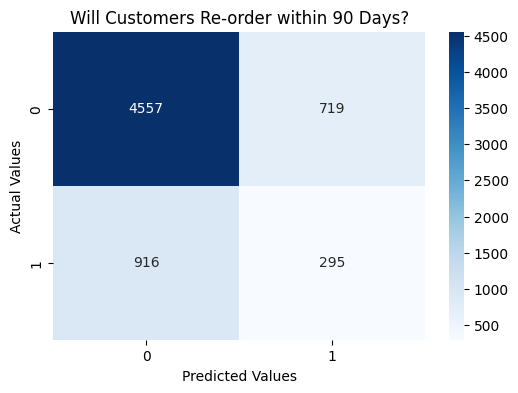

In [ ]:
calculateAndPrintConfusionHeatMap(y_validation, rf_val_y_pred)

Random Forest model performs worst with only an increase in net revenue of 1116.25 € due to higher number of false negatives even though there are more true negatives compared to XGBoost. As false negatives have larger negative impact, the higher number of true negatives cannot compensate the loss as well.

#### **5.2.2 Adaboost**

In [ ]:
#best_adaboost_model = loadModel("Best_Adaboost_Model")

columns_model = best_adaboost_model.feature_names_in_

X_train_ab = X_train[columns_model]
X_validation_ab = X_validation[columns_model]

In [ ]:
ab_exp_rev, ab_val_y_pred, ab_val_accuracy = printModelStats(best_adaboost_model, X_train_ab, X_validation_ab, y_train, y_validation)

Training Accuracy: 0.62
Validation Accuracy: 0.64

Validation Set Results:
Net Revenue: 1453.75
Revenue: 4373.75
Loss: -2920


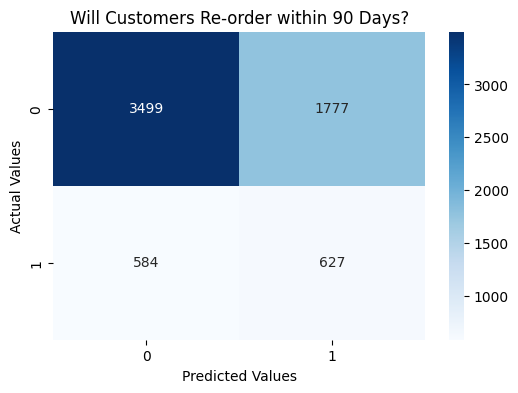

In [ ]:
calculateAndPrintConfusionHeatMap(y_validation, ab_val_y_pred)

Adaboost performs close to XGBoost with less false negatives than XGBoost. However, there are way more false positives which reduces revenue too much to compensate the gains made by a reduction of false negatives.

#### **5.2.3 XGBoost**

In [ ]:
#best_xgboost_model = loadModel("Best_XGBoost_Model")

columns_model = best_xgboost_model.feature_names_in_

X_train_xgb = X_train[columns_model]
X_validation_xgb = X_validation[columns_model]

In [ ]:
xgb_exp_rev, xgb_val_y_pred, xgb_val_accuracy = printModelStats(best_xgboost_model, X_train_xgb, X_validation_xgb, y_train, y_validation)

Training Accuracy: 0.79
Validation Accuracy: 0.68

Validation Set Results:
Net Revenue: 1486.25
Revenue: 4866.25
Loss: -3380


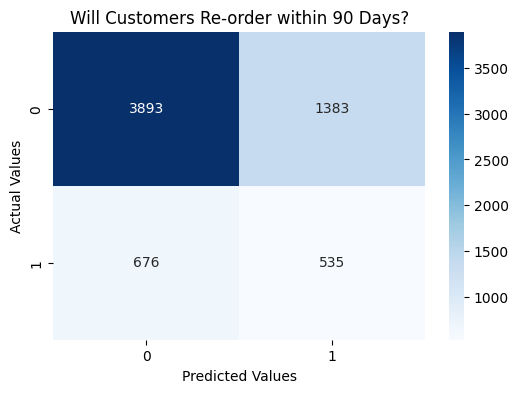

In [ ]:
calculateAndPrintConfusionHeatMap(y_validation, xgb_val_y_pred)

XGBoost performs best the highest net revenue (even though it is close to Adaboost). Overall the balance between false positives and false negatives led me to choose XGBoost as the final model for further investigation. More details are explained in the presentation slides

## **6. Model Interpretation**

### **6.1 Functions**

In [ ]:
#Source: Lecture Slides
def plotPermutationFeatureImportance(model, metrics, X_val, y_val):

  #Calculate pfi scores
  pfi_scores = {}

  metrics = ["balanced_accuracy", "recall", "precision"]

  for metric in metrics:
    pfi_scores[metric] = permutation_importance(model, X_val, y_val, scoring = metric)

  #Gets features
  features = X_val.columns.to_numpy() if hasattr(X_val, "columns") else np.arange(X_val.shape[1])

  #Automatically adjust row and column count for plot to have max 3 plots per row.
  n_metrics = len(metrics)
  row_count = (n_metrics + 2) // 3
  column_count = min(n_metrics, 3)

  #Adjust height of plot depending on number of rows
  fig_height = 3 * row_count

  #Create subplots
  fig, ax = plt.subplots(nrows = row_count, ncols = column_count, figsize = (12, fig_height))
  ax = np.atleast_1d(ax).flatten()

  top = 10

  for k, metric in enumerate(metrics):

    scores = pfi_scores[metric]["importances_mean"]
    srtd = np.argsort(-scores)

    ax[k].barh(y = np.arange(0, top), width = scores[srtd[:top]], color = "#514b4b", alpha = 0.6)

    for i in range(top):
      ax[k].text(0.001, i - 0.15, features[srtd[i]])

    ax[k].set_yticks([])
    ax[k].set_xlabel("Permutation Feature Importances")
    ax[k].set_title(f"Scored using {metric}")

In [ ]:
#Source: Lecture Slides
def plotPartialDependencePlot(model, Xtrn, features, kind = "average", response_method = "predict_proba"):

  fig, ax = plt.subplots(figsize = (12, 8))

  #Creates the PDPs
  pd_disp = pdp.from_estimator(model, Xtrn, features = features, feature_names = list(Xtrn.columns), kind = kind, response_method = response_method, ax=ax)

  #Add space between the plots
  fig.tight_layout(pad = 3.0)

  #Adds grey line colors to match the theme of the presentation slides
  for subplot in pd_disp.axes_.flat:
        if hasattr(subplot, "lines") and subplot.lines:
          for line in subplot.lines:
            line.set_color("#514b4b")

  plt.show()

### **6.2 Permutation Feature Importance**

In [ ]:
metrics = ["balanced_accuracy", "recall"]

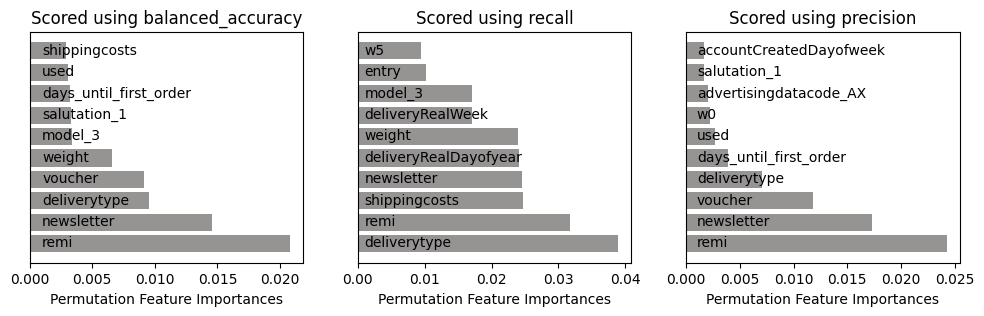

In [ ]:
plotPermutationFeatureImportance(best_xgboost_model, metrics, X_validation_xgb, y_validation)

Most important features:

- Remi = Number of remitted / returned items
- Newsletter = Indicates if customer is subscribed to newsletter
- Shipping Costs = Indicates if customer paid shipping cost
- Delivery Type = Indicates if order was dispatched or collected
- Voucher = If customer redeemed a voucher
- Weight = Weight of Shipment




### **6.3 Partial Dependence Plots (PDP)**

In [ ]:
features = ["remi", "newsletter", "shippingcosts", "deliverytype", "voucher", "weight"]

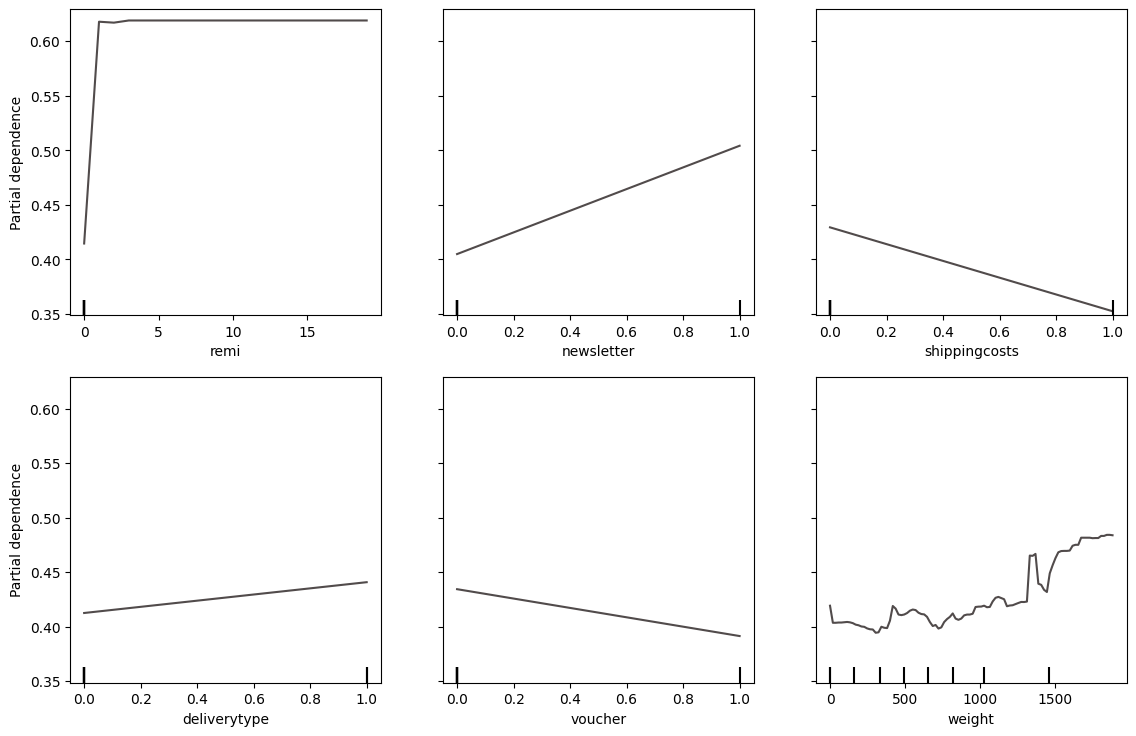

In [ ]:
plotPartialDependencePlot(best_xgboost_model, X_validation_xgb, features)

### **6.4 SHAP**

In [ ]:
explainer_xgb = shap.TreeExplainer(best_xgboost_model) #Get SHAP explainer
shap_values_xgb = explainer_xgb(X_validation_xgb, check_additivity = False) #Get SHAP Values

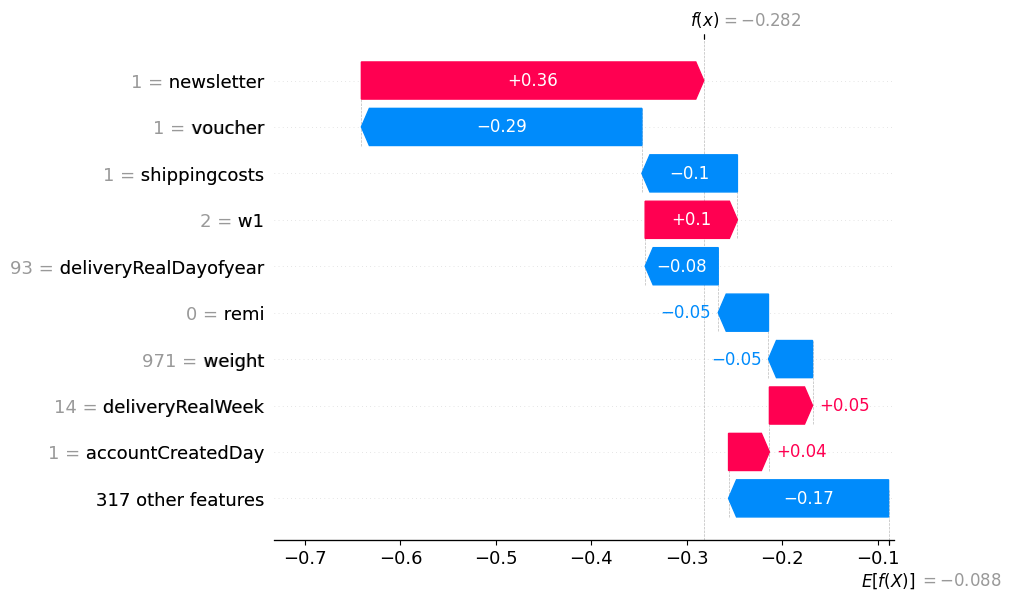

In [ ]:
shap.plots.waterfall(shap_values_xgb[0])

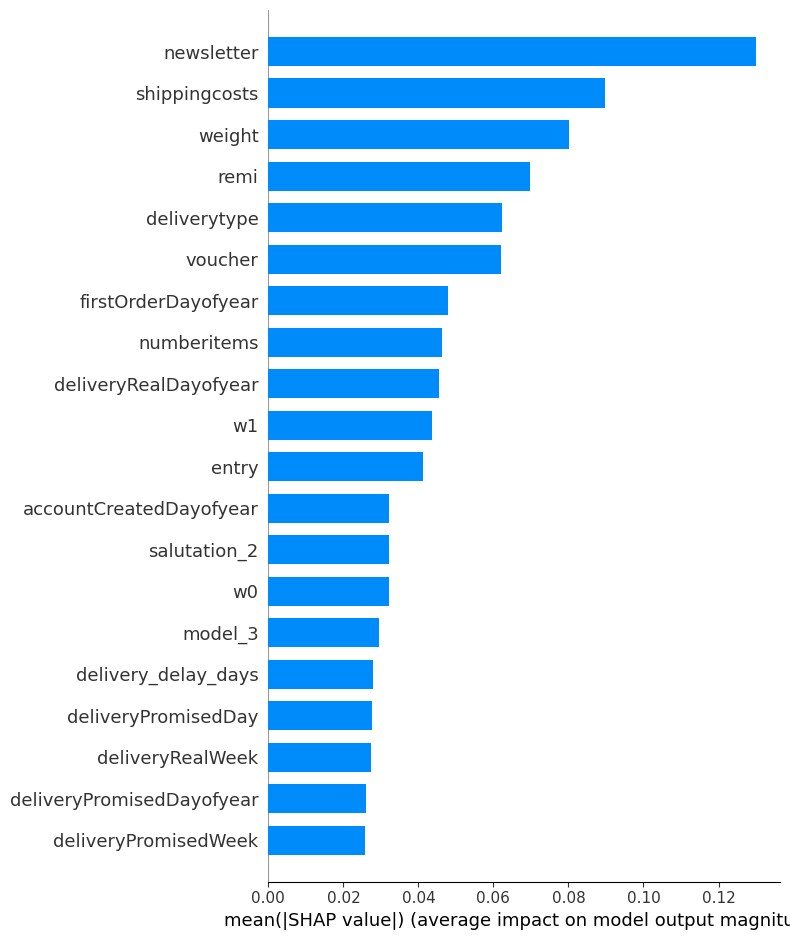

In [ ]:
shap.summary_plot(shap_values_xgb, feature_names = X_validation_xgb.columns, plot_type = "bar")

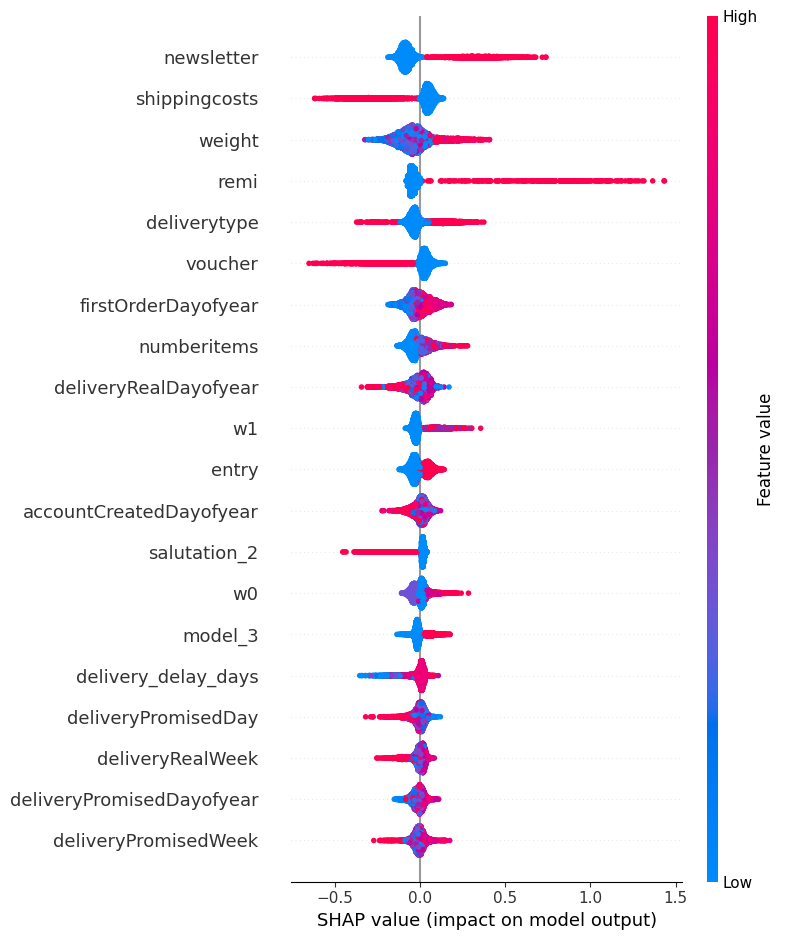

In [ ]:
shap.summary_plot(shap_values_xgb, feature_names=X_validation_xgb.columns)

Similar observations:
- Newsletter unsubscribed customers have a big negative impact on retentions while  subscribing has a positive impact.
- Paying Shipping Cost has big negative impact on retentions.
- Large weight has positive impact while small weight has both positive and big negative impacts.  
- Higher number of remitted items has minor positive impacts while low number has larger negative impacts.
- Delivery Type has mixed results. Order collection has both negative and positive impact while dispatched orders have  negative impact on retentions.
-Having used a voucher previously reduced likelihood of another purchase.




## **7. Making Predictions on Test Set**

In [ ]:
X_test = test_data.reindex(columns = best_xgboost_model.feature_names_in_, fill_value = 0)

In [ ]:
test_y_pred = best_xgboost_model.predict(X_test)

In [ ]:
test_data_original["target90_predicted"] = test_y_pred

In [ ]:
test_data_export = test_data_original[["customernumber", "target90_predicted"]]

In [ ]:
test_data_export.to_csv("test_data_predictions.csv")